### **MA5204: Aprendizaje de Máquinas**

**Departamento de Ingeniería Matemática, Universidad de Chile**

**Profesor:** Felipe Tobar

**Ayudantes:** Alejandro Cuevas, Mauricio Araneda, Mauricio Romero

# Regresión Logística

Este notebook es un demo de como implementar regresión logística de 2 formas, la primera es definir la verosimilitud como una función y optimizar usando BFGS, la segunda es usando funciones de sklearn.

### Modelo

Comenzamos definiendo el modelo de regresión logística, donde de la probabilidad de la clase $y$, condicional a los datos $x$ y los pesos $w$ es,

$$p(y_i|x_i, \mathbf{w}) = \text{Ber}(y_i|\sigma(\mathbf{w}x_i)) = \sigma(\mathbf{w}x_i)^{y_i} (1- \sigma(\mathbf{w}x_i))^{1-y_i} $$

De esta forma, podemos expresar la log posterior negativa, es decir verosimilitud del modelo más un prior en $w$ (en este caso Gaussiano), en función de los datos $x$ y parametros $w$,


$$ NLP = J(\mathbf{w}) = \sum_{i=1}^{D}y_i \log \sigma(\mathbf{w}x_i) + (1-y_i)\log(1-\sigma(\mathbf{w}x_i))  + ||\mathbf{w}||^2$$

Utilizaremos __máximo a posteriori__, pero __no__ tenemos expresión analítica para los pesos $w$ óptimos, por lo que deberemos utilizar métodos de optimización numérica, en particular optimizaremos usando BFGS.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# dataset mauna loa
from sklearn.datasets import fetch_mldata 

In [2]:
# contexto notebook  y escala de fuente
sns.set_context('notebook', font_scale=1.4)

# estilo, fondo blanco con 'ticks' en los ejes
sns.set_style('ticks')

# tamaño por defecto de las figuras
plt.rcParams['figure.figsize'] = (10, 5)

### Cargamos datos y dividimos en entrenamiento y test

Text(0.5, 1.0, 'Datos')

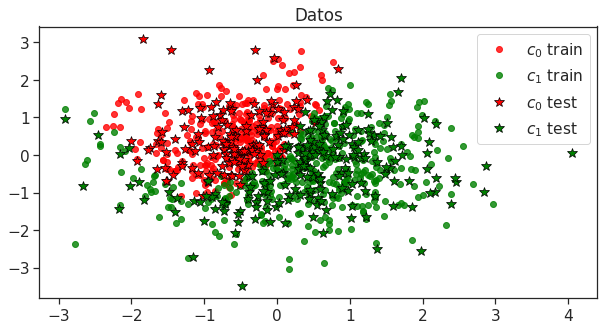

In [3]:
# funcion para dividir entre entrenamiento y test
from sklearn.model_selection import train_test_split

# cargar datos
data = np.loadtxt('../datos/datos_reg_log.txt', delimiter=',')

# dividimos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    data[:2, :].T, data[2, :].T, test_size=0.33)

# graficamos
plt.plot(X_train[y_train==0, 0], X_train[y_train==0, 1], 'ro', alpha=0.8, label=r'$c_0$ train')
plt.plot(X_train[y_train==1, 0], X_train[y_train==1, 1], 'go', alpha=0.8, label=r'$c_1$ train')
plt.plot(X_test[y_test==0, 0], X_test[y_test==0, 1], 'r*',
         label=r'$c_0$ test', markeredgecolor='k', ms=10, markeredgewidth=0.7)
plt.plot(X_test[y_test==1, 0], X_test[y_test==1, 1], 'g*',
         label=r'$c_1$ test', markeredgecolor='k', ms=10, markeredgewidth=0.7)
plt.legend()
plt.title('Datos')

## Opcion 1: Hecho a mano

Creamos el modelo definiendo funciones:
1. Sigmoidea
2. Log posterior negativa para reg log
3. El jacobiano de (2)

y luego optimizamos por max verosimilitud

### Definición modelo

In [4]:
def sig(w, x):
    """
    Retorna la sigmoidea de (w @ x)
    """
    # agrego fila de unos
    x_tilda = np.c_[np.ones(x.shape[0]), x]
    a = x_tilda @ w
    
    return 1 / (1 + np.exp(-a))

def rl_nlp(w, x, y, rho=0.1):
    """
    Log posterior negativa del modelo de
    regresión logística.
    """
    # log verosimilitud negativa
    nll = (y * np.log(sig(w, x)) + (1 - y) * np.log(1 - sig(w, x))).sum()
    # prior
    nll += rho * (w**2).sum()
    
    return -nll

def jac_nlp(w, x, y, rho=0.1):
    """
    Jacobiano de la log posterior negativa.
    """
    x_tilda = np.c_[np.ones(x.shape[0]), x]
    
    return ((sig(w, x) - y) @ x_tilda)

### Optimizar

Optimizamos la log-posterior-negativa usando BFGS

In [5]:
# optimizador de scipy
from scipy.optimize import minimize as fmin

# condicion inicial
w0 = np.zeros(X_train.shape[1] + 1)
# argumentos
args = (X_train, y_train, 0.1)

opt = fmin(
    rl_nlp,                  # funcion objetivo
    w0,                      # condicion inicial
    args,                    # argumentos fijos funcion objetivo
    jac=jac_nlp,             # gradientes
    method='BFGS',           # metodo
    tol=1e-10,               # tolerancia numerica
    options={'disp': True, 'maxiter': 5000}) # opciones extra

w_opt = opt.x
print('Pesos optimos (hecho a mano)', w_opt)
print('NLL', opt.fun)

         Current function value: 239.685593
         Iterations: 11
         Function evaluations: 93
         Gradient evaluations: 81
Pesos optimos (hecho a mano) [ 0.64473511  2.09482784 -2.1212336 ]
NLL 239.68559265702189


/home/alejandro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/home/alejandro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply


### Predicción
Realizamos prediccion

In [6]:
def lr_predict(w, x, tresh=0.5):
    """
    Prediccion para regresión logística
    """
    # probabilidad de clase data el modelo y obs
    p_y_w = sig(w, x)
    
    # asigna clase segun umbral
    y_pred = (p_y_w >= tresh).astype(int)
    
    return y_pred

y_pred1 = lr_predict(w_opt, X_test)

In [7]:
# metrica de accuracy
from sklearn.metrics import accuracy_score

print('Pesos optimos (hecho a mano)', w_opt)
print('Accuracy en conjunto de test (hecha a mano)', accuracy_score(y_test, y_pred1))

Pesos optimos (hecho a mano) [ 0.64473511  2.09482784 -2.1212336 ]
Accuracy en conjunto de test (hecha a mano) 0.9030303030303031


## Opcion 2: Sklearn

Importamos y aplicamos la función

In [8]:
# importamos de sklearn
from sklearn.linear_model import LogisticRegression

# crear instancia
logr = LogisticRegression(solver='lbfgs', fit_intercept=True)

# entrenar
logr.fit(X_train, y_train)

# predecir
y_pred2 = logr.predict(X_test)

# mostrar pesos optimos
print('Pesos optimos sklearn', logr.intercept_, logr.coef_)

print('Accuracy en conjunto de test (sklearn)', accuracy_score(y_test, y_pred2))

Pesos optimos sklearn [0.61969294] [[ 1.99241618 -2.01557904]]
Accuracy en conjunto de test (sklearn) 0.9030303030303031


## Grafico comparativo de ambas implementaciones

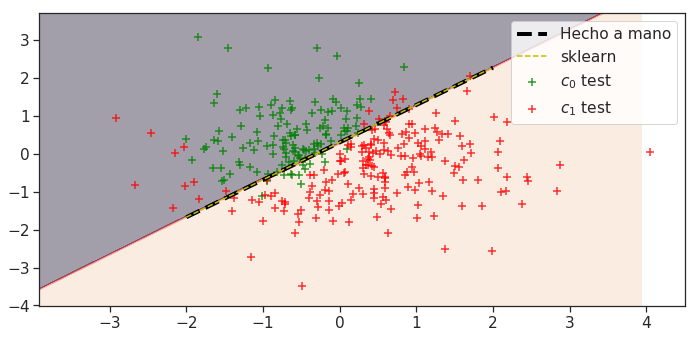

In [9]:
# plano encontrado
line_x = np.linspace(-2, 2, 100)
line_y = -opt.x[1] / opt.x[2] * line_x - opt.x[0] / opt.x[2]
line_y2 = -logr.intercept_ / logr.coef_[0][1] - logr.coef_[0][0] / logr.coef_[0][1] * line_x

# grid de puntos para graficar region
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.06),
                     np.arange(y_min, y_max, 0.06))

# clasificar grid
Z = lr_predict(w_opt, np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.plot(line_x, line_y, '--k', lw=4, label='Hecho a mano')
plt.plot(line_x, line_y2, '--y', label='sklearn')
plt.scatter(
    X_test[y_test == 0, 0],
    X_test[y_test == 0, 1],
    c='g',
    marker='+',
    s=50,
    alpha=0.8,
    label=r'$c_0$ test')
plt.scatter(
    X_test[y_test == 1, 0],
    X_test[y_test == 1, 1],
    c='r',
    marker='+',
    s=50,
    alpha=0.8,
    label=r'$c_1$ test')
plt.legend()

plt.tight_layout()

## Datos reales: Breast cancer wisconsin

Para mostrar con un dataset más realista, se quiere clasificar si un paciente presenta cancer o no dado ciertas mediciones.

In [10]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
print(data.keys())

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [11]:
print(data.feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.data, data.target, test_size=0.33, random_state=42)

In [13]:
# crear instancia
logr = LogisticRegression(solver='lbfgs', max_iter=5000)

# entrenar
logr.fit(X_train, y_train)
logr.coef_

# predecir
y_pred3 = logr.predict(X_test)

In [14]:
print('accuracy on test set', accuracy_score(y_test, y_pred3))

accuracy on test set 0.9680851063829787
